1. Read in the data
2. Make discriminator (model)
3. Make Generator (model)
4. Make loss functions for both



In [36]:
import fastbook
from fastbook import *
#import torch
#print(torch.cuda.is_available())
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from PIL import Image

In [37]:
%matplotlib inline

In [38]:
test = "blues.00000.wav.png"
a = re.findall(r'^([^.]+)', test)
a

['blues']

In [39]:
path = Path.BASE_PATH = r".\all"

music = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items= get_image_files,
        splitter = RandomSplitter(seed=23),
        get_y = using_attr(RegexLabeller(r'^([^.]+)'), 'name'))
dls = music.dataloaders(path, bs=4)
dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [40]:
music.summary(path)

Setting-up type transforms pipelines
Found 999 items
2 datasets of sizes 800,199
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      all\metal.00037.wav.png
    applying PILBase.create gives
      PILImageBW mode=L size=854x66
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      all\metal.00037.wav.png
    applying partial gives
      metal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImageBW mode=L size=854x66, TensorCategory(6))


Found 999 items
2 datasets of sizes 800,199
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is ch

In [41]:

#torch.cuda.empty_cache()
#dls.show_batch(nrows=2, ncols=2)
#dls.show_batch(max_n=9, figsize=(8,6))


#def clear_memory():
#    gc.collect()
#    torch.cuda.empty_cache()

# Discriminator

In [42]:
#torch.cuda.empty_cache()
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(218112, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image):
        return self.discriminator(image)

#discriminator = Discriminator().cuda()
#batch_x,y = dls.valid.one_batch()
#x, y = batch_x.cuda(), y.cuda()
#out = discriminator(batch_x)
#out

In [43]:
#clear_memory()

# Generator

In [44]:
#854x63 53802
#class Generator(nn.Module):
#    def __init__(self, z_dim=10):
#        super(Generator, self).__init__()
#        self.generator = nn.Sequential(
#            nn.Linear(10,100),
#            nn.Linear(100,53802),
#            nn.Sigmoid()
#        )
#    def forward(self, x):
#        return self.generator(x)


#x = torch.rand(4, 10).cuda()
#gen = Generator().cuda()
#y = gen(x)
#del y
#clear_memory()

In [45]:
class Reshape(nn.Module):
    """
    Class for performing a reshape as a layer in a sequential model.
    """
    def __init__(self, shape=[]):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)
    
    def extra_repr(self):
            # (Optional)Set the extra information about this module. You can test
            # it by printing an object of this class.
            return 'shape={}'.format(
                self.shape
            )

In [46]:
class AreTwoGenTwo(nn.Module):
    def __init__(self, z_dim=10, img_size=(64,16,213)):
        super(AreTwoGenTwo, self).__init__()
        self.flat_img = int(np.prod(img_size))
        self.generator = nn.Sequential(
            # Fully connected layers
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            #nn.ReLu(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, self.flat_img),
            #nn.ReLu(True),
            nn.LeakyReLU(0.2, inplace=True),
            Reshape(img_size),
            nn.ConvTranspose2d(64,32, 5, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32,1,4, stride=2, padding=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.generator(x)

#x = torch.rand(4, 10).cuda()
#gen = AreTwoGenTwo().cuda()
#y = gen(x)

In [47]:
#y.shape

In [48]:
#image = y[0,0].detach().to("cpu").numpy() 

#plt.figure(figsize=(40,10))
#plt.imshow(image)

In [49]:
#im = Image.fromarray(image).convert('RGB')
#im.save("Generated.jpeg")

## Discriminator Loss

In [50]:
def get_noise(num_images, z_dim, device="cuda"):
    noise = None
    if device == "cuda":
        noise = torch.rand(num_images,z_dim , device=device).cuda()
    else:
        noise = torch.rand(num_images, z_dim)
    return noise


In [51]:
def get_disc_loss(gen, disc, criterion, real_input, num_images, z_dim, device="cuda"):
    '''
    Return Loss of discriminator 
    Params: 
    Gen: Geneartor model
    Disc: Discrimiator Model
    criterion: Loss function
    Real Input: Our data set images
    Num_images: Len(real input)
    z_dim: Dimention of our noise vector
    Return a loss value for 1 batch
    '''
    
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 66, 854))
    fake_images.detach()
    fake_loss = criterion(disc(fake_images), torch.zeros((num_images,1),device=device))
    real_loss = criterion(disc(real_input), torch.ones((num_images,1),device=device))
    disc_loss = (fake_loss + real_loss)/2
    return disc_loss

def test_disc():
    gen = AreTwoGenTwo().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    x,y = dls.valid.one_batch()
    num_images = len(x)
    z_dim = 10
    loss = get_disc_loss(gen, disc, criterion, x, num_images, z_dim)
    return loss
    
#loss = test_disc()
#print(loss)


In [52]:
#gen = AreTwoGenTwo().cuda()
#disc = Discriminator().cuda()

In [53]:
#print(gen)

In [54]:
#print(disc)

In [55]:
a = torch.zeros(4,1)

In [56]:
a

tensor([[0.],
        [0.],
        [0.],
        [0.]])

# Generator Loss

In [57]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device="cuda"):
    '''
    Returns the loss of the generator
    Params: 
    Gen: Generator Model
    Disc: Discrimiator Model
    Criterion: Loss Function
    num_images: The number of images the generator should produce
    z_dim: The dim of the noise vector
    Device: What device we run it on
    '''
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 66, 854))
    fake_images.detach()
    prediction = disc(fake_images)
    gen_loss = criterion(prediction, torch.ones(num_images,1, device=device))
    return gen_loss

def test_gen_loss():
    gen = Generator().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    num_images = 4 
    z_dim = 10
    loss = get_gen_loss(gen, disc, criterion, num_images, z_dim)
    return loss

#loss = test_gen_loss()
#print(loss)
#loss = None

# Training

In [58]:
#clear_memory()

In [59]:
criterion = nn.BCELoss()
n_epochs = 20
z_dim = 10
#batch_size = 4

device = "cuda"
#device = "cpu"
gen = AreTwoGenTwo().to(device)
gen_opt = torch.optim.Adam(gen.parameters())
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters())

cur_step = 0 
disc_loss_hist = [] 
gen_loss_hist = []

for epoch in range(n_epochs):
    disc_loss_batch = 0.0
    gen_loss_batch = 0.0
    batch_size = len(dls.train)
    for batch in dls.train:
        real_images, *_ = batch
        real_images = real_images.to(device)
        num_images = len(real_images)
        #Train discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real_images, num_images, z_dim, device)
        disc_loss_batch+=disc_loss.item()
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        #Train Generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
        gen_loss_batch+=gen_loss.item()
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        #print("Batch")
    print("Epoch: " + str(epoch))
    print(disc_loss_batch/batch_size)
    print(gen_loss_batch/batch_size)
    disc_loss_hist.append(disc_loss_batch/batch_size)
    gen_loss_hist.append(gen_loss_batch/batch_size)
    

        
        

Epoch: 0
0.48762961593922227
2.37448983553797
Epoch: 1
0.5002314567100257
1.7279259792715311
Epoch: 2
0.5894553581252694
1.7133560071885585
Epoch: 3
0.6303072458226233
1.6831062068417668
Epoch: 4
0.38952179019572214
2.6117454349994658
Epoch: 5
0.3866196486959234
3.4151709371805192
Epoch: 6
0.45547356695868074
2.1011668834090234
Epoch: 7
0.5048154936358332
1.6928782830387354
Epoch: 8
0.609645112361759
1.5621174131333828
Epoch: 9
0.601965953335166
1.0268792015314103
Epoch: 10
0.5173303801566362
1.393765293508768
Epoch: 11
0.5866161214001476
1.3974239106476307
Epoch: 12
0.5744272918626666
1.1647260473668575
Epoch: 13
0.5795896466821432
1.2837657450139524
Epoch: 14
0.5053731277771294
1.5567315090028568
Epoch: 15
0.6301110285520554
0.9673836483806372
Epoch: 16
0.6522518627345562
1.0465386828780174
Epoch: 17
0.5764762534946203
1.0984282875061036
Epoch: 18
0.5685629998520016
1.3418301936984063
Epoch: 19
0.5207137353718281
1.8030261732824147


In [60]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    6725 MB |    9286 MB |   26825 GB |   26819 GB |\n|       from large pool |    6706 MB |    9267 MB |   26746 GB |   26739 GB |\n|       from small pool |      19 MB |      22 MB |      79 GB |      79 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    6725 MB |    9286 MB |   26825 GB |   26819 GB |\n|       from large pool |    6706 MB |    9267 MB |

# TODO
1. ~~Make list~~
2. ~~[Get GPU working?](https://pytorch.org/docs/stable/notes/faq.html)~~
3. ~~Change model for generator Transposed convolution~~
4. Fix Checkerboard Pattern
5. Train on single Genre
6. Upgrade our Discriminator (More CNN)
7. "Tunning" 

    a. Stride

    b. ~~CNN Nonsense~~
8. Run that shit all day
9. Train to generate specific Genere
10. Increase image resolution 

1. Test on your machine
2. reduce linear layers size
3. Consolidate loss functions

In [61]:
a=5
a+=10
a

15

C:\Users\ldscho\AppData\Local\Temp/ipykernel_22208/1637938815.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\ldscho\AppData\Local\Temp/ipykernel_22208/1637938815.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


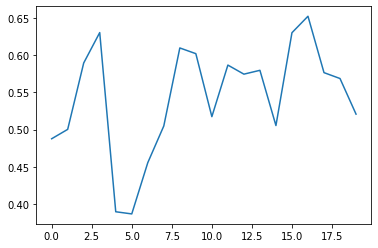

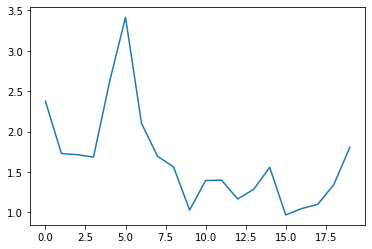

In [62]:
fig,ax = plt.subplots()
ax.plot(disc_loss_hist)
fig.show()

fig,ax = plt.subplots()
ax.plot(gen_loss_hist)
fig.show()

In [72]:
def make_image(gen):
    x = torch.rand(4, 10).to("cuda")
    y = gen(x)
    return y
y = make_image(gen)
image = torch.reshape(y, (4, 1, 66, 854))


In [64]:
disc(y)

tensor([[0.0039],
        [0.2127],
        [0.0390],
        [0.0639]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [65]:
batch_x,y = dls.valid.one_batch()
x, y = batch_x.cuda(), y.cuda()
disc(x)

TensorImageBW([[0.9660],
        [0.9975],
        [0.9943],
        [0.8117]], device='cuda:0', grad_fn=<AliasBackward0>)

In [73]:
y = y.detach().to("cpu").numpy()
y.ndim
image = image[0,0].detach().to("cpu").numpy() 


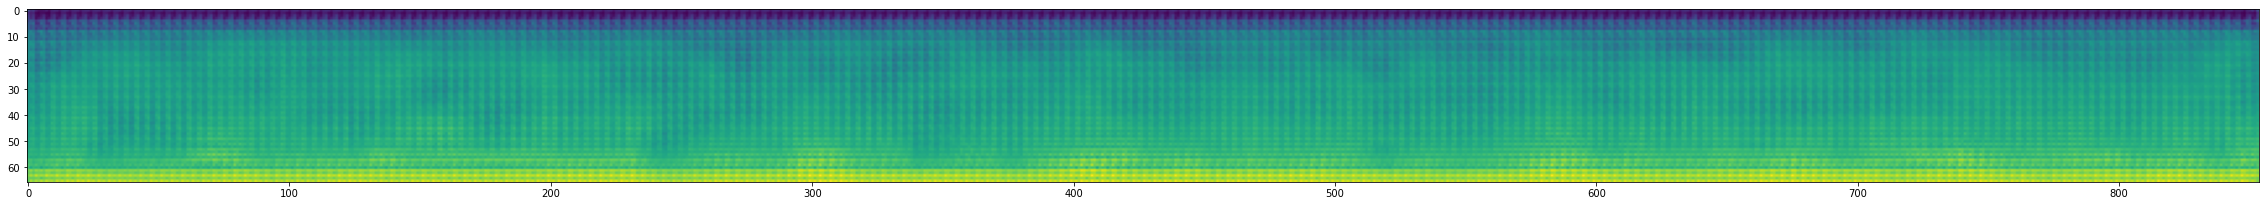

In [75]:

plt.figure(figsize=(40,10))
plt.imshow(image)

In [67]:
im = Image.fromarray(image).convert('RGB')
im.save("Generated.jpeg")